In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_fBiPotDDims_NonSep.recursive_Markovian_PostMeanScore_fBiPot8DimsNS_T256_H05_tl_110data_StbleTgt_FULLDATA import get_config

In [2]:
config = get_config()
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 10240
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [3]:
import pandas as pd
def get_drift_files(config, root_dir ):
    ts_type = f"{config.ndims}DDimsNS"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/8DDimsNS/"
    true_files = []
    local_files = []
    mses = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file:
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
            elif "bwidx" in file and "MSEs" not in file:
                mses_full = pd.read_parquet(root_nadaraya_dir+file)
                mses.append(mses_full)
    mses = pd.concat(mses).sort_values("bw", axis=0).dropna()
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[4][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws, mses

In [4]:
config = get_config()
true_files, local_files, bws, mses = get_drift_files(config=config, root_dir=root_dir)

In [5]:
print(mses)

          bw          mse
0   0.000282  2074.051270
1   0.000372  2074.049561
2   0.000491  2074.011475
3   0.000649  2073.917969
4   0.000857  2073.766113
5   0.001131  2073.322510
6   0.001493  2072.399414
7   0.001972  2071.119629
8   0.002603  2069.149658
9   0.003437  2065.528564
10  0.004538  2058.802002
11  0.005992  2046.263916
12  0.007912  2023.274292
13  0.010446  1985.213989
14  0.013793  1921.021851
15  0.018211  1810.266724
16  0.024046  1622.803711
17  0.031749  1322.973511
18  0.041919   898.067871
19  0.055348   442.639404
20  0.073079   149.992493
21  0.096490    44.655346
22  0.127401    21.779869
23  0.168214    21.360575
24  0.222102    26.820938
25  0.293252    33.468418
26  0.387196    39.265690
27  0.511235    43.743652
28  0.675010    46.972099
29  0.891251    49.141628
30  1.135011    50.378342
31  1.445440    51.191685
32  1.840772    51.716965
33  2.344229    52.051487
34  2.985383    52.262287
35  3.801894    52.394104
36  4.841724    52.476124
37  6.165950

Text(0.5, 1.0, 'Minimum MSE is (21.360575, 23)')

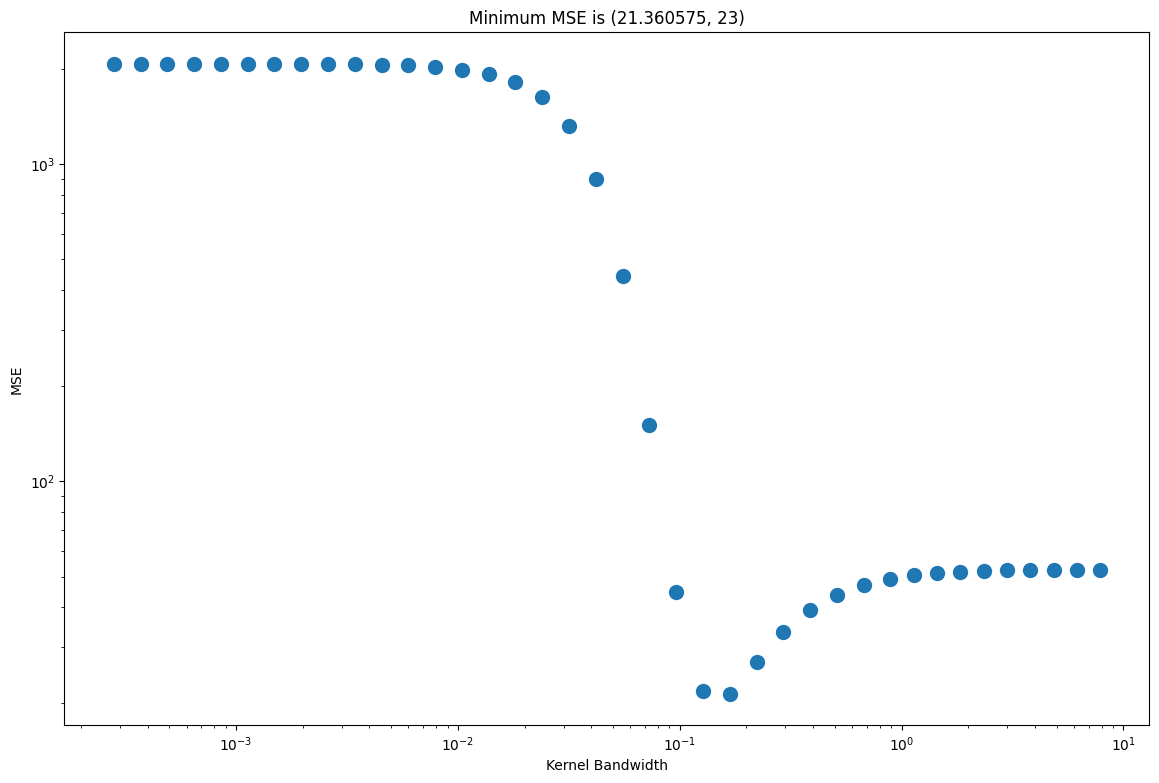

In [6]:
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("MSE")
ax.set_xlabel("Kernel Bandwidth")
ax.set_title(f"Minimum MSE is {mses.iloc[np.argmin(mses.mse), 1], np.argmin(mses.mse)}")